In [20]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import sys
import sklearn
import io
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
import warnings
warnings.filterwarnings("ignore")
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from scikeras.wrappers import KerasClassifier
from keras.utils import to_categorical
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline



In [46]:
#loading the dataset 
data=pd.read_csv('UNSW_NB15_tset.csv')

In [3]:
data.columns

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

# Preprocessing

In [4]:
#by droping irrelevant columns we can simplify our dataset and increase the performance of the ML model on dataset
data = data.drop(columns=['attack_cat'])

In [5]:
# Handle missing values (fill with 0 in this example)
data.fillna(0, inplace=True)

In [6]:
# Step 2: Identify numeric and categorical features is a crucial step in our preprocessing 
#using the select_dtypes to filter columns in the data that have data types float64 and int64 
#the columns.tolist : return our columns filtered and convert it to a list that contain the names of numeric columns 
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
#for categorical features we filter columns by object meaning that columns may contain strings or other data non numeric 
categorical_features = data.select_dtypes(include=['object']).columns.tolist()

In [7]:
# Feature Scaling for numeric features
scaler = StandardScaler()
data[numeric_features] = scaler.fit_transform(data[numeric_features])

In [8]:
# One-Hot Encoding for categorical features
data = pd.get_dummies(data, columns=categorical_features)

In [9]:
# Split into features (X) and label (y)
X = data.drop(columns=['label'])
y = data['label']

In [10]:
# Reshape input data for LSTM
sequence_length = 10 
num_features = 43

In [11]:
def reshape_sequence_data(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequence = data[i:i + sequence_length]
        sequences.append(sequence)
    return np.array(sequences)

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
X_train = reshape_sequence_data(X_train, sequence_length)
X_test = reshape_sequence_data(X_test, sequence_length)

In [31]:
# Sample data 
X_train = np.random.rand(1000, 10, 5)  # 1000 samples, 10 timesteps, 5 features
y_train = np.random.randint(2, size=1000)  # Binary labels (0 or 1)

# RNN model with LSTM

In [32]:
# Perform K-Fold Cross-Validation split
k = 5  # Number of folds
#shuffle is 'true' so that the data is randomly shuffled before the split 
kf = KFold(n_splits=k, shuffle=True)

# Lists to store performance metrics for each fold
accuracy_scores = []
loss_values = []

In [33]:
# Define the RNN model architecture
model = tf.keras.Sequential([
    #we choose to work with LSTM (Long Short-Term Memory), which is a type of recurrent neural network (RNN) to handle sequential data 
    #that contain two arguments : 
       #*the number of units that control the capacity of LSTM ,if nb is higher the LSTM capture more patterns 
       #*input shape : that represent our data 
    tf.keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])),
    #working with DENSE that from TensorFlow's Keras API that represent the connection with the neurons in the networks , and it contain two 
     #arguments :
       #*number of neurons or units of dense that control the number of output units 
       #*activation : is a optional parameter , here we use the'relu(Rectified Linear Unit)' so that every negative value is set to 0
    tf.keras.layers.Dense(64, activation='relu'),
    #It compresses the output between 0 and 1, representing the probability of the positive class in binary classification problems.
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

In [34]:
#compiling the model contain three parameter
  #*loss: define the function that the model will use during training, 'binary_crossentropy' used in binary classification that predicte probabilities 
  #*optimizer: for the optimization of algorithme we use 'adam' is an optimization algorithm that adjusts the learning rate in training to handle all different types of data
  #*metrics: specifying the metrics that will be computed during training and testing so that it will compute the accuracy(proportion of correctly predicted) metric 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:

# Reset the index of X_train and y_train
X_train = np.array(X_train)
y_train = np.array(y_train)

In [41]:
# Perform K-Fold Cross-Validation
#for the kf.split it return iterators that yield for each fold spliting the data into validation set and training set
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"Fold {fold + 1}/{k}")
    
    # Split data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    # Train the model on this fold
    #The epochs: parameter specifies the number of times that is passed forward and backward through the model in training
    #batch_size: for not updating the weights model each time we specify a batch_size lead us to a faster training if the 
     #the value is big 
    history = model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=64, validation_data=(X_val_fold, y_val_fold))
    #history
    # Evaluate the model
    _, accuracy = model.evaluate(X_val_fold, y_val_fold)  
    accuracy_scores.append(accuracy)
     # Store the loss value for this fold
    loss_values.append(history.history['loss'][-1])
    

Fold 1/5
Epoch 1/10
13/13 [==============================] - 10s 215ms/step - loss: 0.4653 - accuracy: 0.7563 - val_loss: 0.5195 - val_accuracy: 0.7400
Epoch 2/10
13/13 [==============================] - 2s 207ms/step - loss: 0.4537 - accuracy: 0.7825 - val_loss: 0.5129 - val_accuracy: 0.7200
Epoch 3/10
13/13 [==============================] - 3s 287ms/step - loss: 0.4346 - accuracy: 0.7937 - val_loss: 0.5170 - val_accuracy: 0.7450
Epoch 4/10
13/13 [==============================] - 4s 335ms/step - loss: 0.4033 - accuracy: 0.8037 - val_loss: 0.5303 - val_accuracy: 0.7350
Epoch 5/10
13/13 [==============================] - 2s 199ms/step - loss: 0.3830 - accuracy: 0.8213 - val_loss: 0.6003 - val_accuracy: 0.7000
Epoch 6/10
13/13 [==============================] - 4s 327ms/step - loss: 0.3896 - accuracy: 0.8213 - val_loss: 0.6288 - val_accuracy: 0.6900
Epoch 7/10
13/13 [==============================] - 3s 244ms/step - loss: 0.3842 - accuracy: 0.8175 - val_loss: 0.6508 - val_accuracy: 0.7

In [42]:
# Calculate and print average performance metrics across all folds
print(f"Average accuracy: {np.mean(accuracy_scores)}")
print(f"Average loss: {np.mean(loss_values)}")

Average accuracy: 0.7305000007152558
Average loss: 0.14065735675394536


In [43]:
# Display the loss and accuracy during training
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

Training Loss: [0.05554382503032684, 0.051120515912771225, 0.050127867609262466, 0.041677411645650864, 0.03414593264460564, 0.03573083505034447, 0.048734866082668304, 0.03316540643572807, 0.02597968839108944, 0.03391144797205925]
Training Accuracy: [0.9887499809265137, 0.987500011920929, 0.9862499833106995, 0.9900000095367432, 0.9937499761581421, 0.9937499761581421, 0.9912499785423279, 0.9925000071525574, 0.9987499713897705, 0.9925000071525574]
Validation Loss: [0.03791624680161476, 0.046471577137708664, 0.07012210041284561, 0.07340013235807419, 0.06822268664836884, 0.07353547215461731, 0.08315815776586533, 0.12894390523433685, 0.09488075971603394, 0.09792698174715042]
Validation Accuracy: [0.9950000047683716, 1.0, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9800000190734863, 0.9649999737739563, 0.9549999833106995, 0.9649999737739563, 0.9800000190734863]


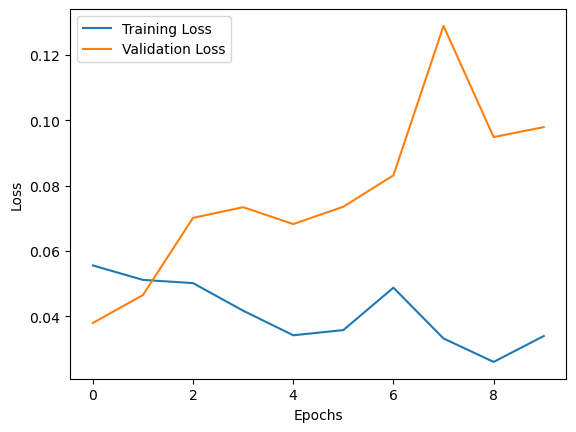

In [44]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

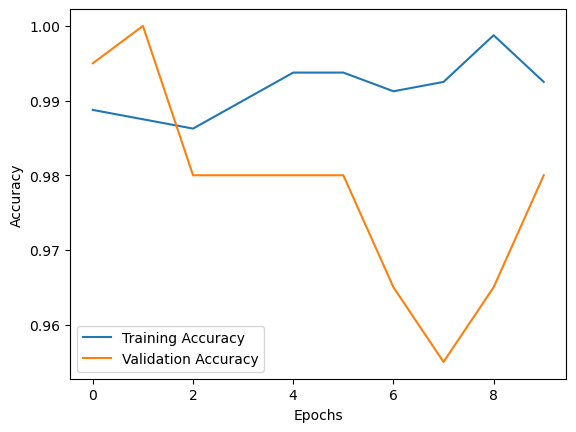

In [45]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()